**PROGRAMA DE PÓS-GRADUAÇÃO EM ENGENHARIA DE RECURSOS HÍDRICOS E AMBIENTAL**  
UNIVERSIDADE FEDERAL DO PARANÁ  
ERHA7016 – HIDROLOGIA ESTOCÁSTICA  

**Autora:** Raquel Ayumi Aita (<raquel.aita@ufpr.br>)

## Preâmbulo

In [1]:
import pandas as pd  # leitura e manipulação dos dados
import numpy as np  # histograma
import seaborn as sns  # box-plot
import scipy.stats as stats  # FDP
import pymannkendall as mk
import pyhomogeneity as hg
import statsmodels as sm
import statsmodels.api as smapi

from ipyleaflet import Map, Marker, basemaps, Popup  # mapas
from ipywidgets import HTML  # widgets

import matplotlib.pyplot as plt
# ajustando gráficos inline
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['charter']

## Leitura e manipulação dos dados

- **Séries escolhidas**

| Posto                     | Código   | Operador | Latitude | Longitude |
|---------------------------|----------|----------|----------|-----------|
| Ponte do Piquiri          | 64795000 | IAT-PR   | -24.56   | -53.13    |
| UHE Santo Antônio do Jari | 290      | ONS      | -0.65    | -52.53    |

- **Nomenclatura**
    - `sj` : UHE Santo Antônio do Jari
    - `pp` : Ponte do Piquiri
    - `df_nome` : var. auxiliar com arquivo original conforme organizado no excel
- **Disposição**
    - Série anual : `pd.Series` com ano como index
    - Série mensal : `pd.DataFrame` com ano em linha e mês em coluna

In [2]:
m = Map(basemap=basemaps.OpenStreetMap.HOT, center=(-11, -53), zoom=3.5)

message1 = HTML()
message1.value = "Ponte do Piquiri"
marker1 = Marker(location=(-24.56, -53.13))
marker1.popup = message1
m.add_layer(marker1)

message2 = HTML()
message2.value = "UHE Santo Antônio do Jari"
marker2 = Marker(location=(-00.65, -52.52))
marker2.popup = message2
m.add_layer(marker2)

display(m)

del m, marker1, marker2, message1, message2, basemaps

Map(center=[-11, -53], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

### UHE Santo Antônio do Jari

In [3]:
# Leitura do arquivo excel
df_sto_antonio_jari = pd.read_excel(
    "sto_antonio_jari.xlsx", sheet_name="Planilha1",
    index_col=0, usecols="A:N",
)

# Criação da variável anual
sj_anual = df_sto_antonio_jari["Média"].drop([
    "min(1931 - 2019)",
    "med(1931 - 2019)",
    "max(1931 - 2019)",
], axis=0)
sj_anual = sj_anual.round()
sj_anual = sj_anual.rename("UHE Sto Antônio do Jari")

# Criação da variável mensal
sj_mensal = df_sto_antonio_jari.drop([
    "min(1931 - 2019)",
    "med(1931 - 2019)",
    "max(1931 - 2019)",
], axis=0)
sj_mensal = sj_mensal.drop("Média", axis=1)

del df_sto_antonio_jari

In [4]:
sj_anual

1931     916.0
1932     706.0
1933    1028.0
1934    1455.0
1935    1015.0
         ...  
2015     953.0
2016     708.0
2017    1076.0
2018    1357.0
2019    1091.0
Name: UHE Sto Antônio do Jari, Length: 89, dtype: float64

In [5]:
sj_mensal

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
1931,576.0,1648.0,798.0,1650.0,1766.0,1775.0,930.0,623.0,332.0,337.0,113.0,446.0
1932,174.0,671.0,894.0,1718.0,841.0,1426.0,846.0,964.0,357.0,156.0,209.0,212.0
1933,773.0,977.0,1044.0,1746.0,2533.0,1214.0,1338.0,1006.0,702.0,186.0,313.0,500.0
1934,368.0,1259.0,1561.0,2110.0,2172.0,3815.0,2569.0,1504.0,704.0,352.0,459.0,592.0
1935,1225.0,886.0,1474.0,1664.0,1386.0,1546.0,1766.0,1017.0,437.0,253.0,228.0,303.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2015,265.0,810.0,1594.0,1871.0,2438.0,1741.0,1163.0,793.0,397.0,178.0,94.0,91.0
2016,204.0,514.0,1328.0,1687.0,1561.0,966.0,1000.0,555.0,343.0,141.0,96.0,102.0
2017,483.0,977.0,2283.0,1971.0,2470.0,1624.0,1331.0,747.0,463.0,268.0,150.0,143.0
2018,436.0,908.0,1098.0,2797.0,3300.0,2591.0,1865.0,1132.0,728.0,419.0,252.0,762.0


### Ponte do Piquiri

In [6]:
# Leitura do arquivo excel
df_ponte_piquiri = pd.read_excel(
    "ponte_piquiri.xlsx", sheet_name="Valores Mensais",
    index_col=0, usecols="A:G",
)
df_ponte_piquiri = df_ponte_piquiri[df_ponte_piquiri.index.year > 1970]
df_ponte_piquiri = df_ponte_piquiri[df_ponte_piquiri.index.year < 2019]

# Criação da variável anual
pp_anual = []
for ano in range(1971, 2019):
    pp_anual.append(df_ponte_piquiri["Média"][df_ponte_piquiri.index.year == ano].mean())
pp_anual = pd.Series(pp_anual, index=range(1971,2019), name="Ponte do Piquiri")
pp_anual = pp_anual.round()

# Criação da variável mensal
meses = [
    "Jan", "Fev", "Mar", "Abr", 
    "Mai", "Jun", "Jul", "Ago",
    "Set", "Out", "Nov", "Dez",
]
pp_mensal = {
    meses[mes]:df_ponte_piquiri["Média"][df_ponte_piquiri.index.month == mes+1].tolist()
    for mes in range(12)
}
pp_mensal = pd.DataFrame(pp_mensal, index=range(1971,2019))

del ano, meses, df_ponte_piquiri

In [7]:
pp_anual

1971    333.0
1972    319.0
1973    281.0
1974    198.0
1975    264.0
1976    303.0
1977    186.0
1978    122.0
1979    317.0
1980    291.0
1981    297.0
1982    418.0
1983    611.0
1984    255.0
1985    184.0
1986    236.0
1987    359.0
1988    196.0
1989    340.0
1990    453.0
1991    172.0
1992    449.0
1993    344.0
1994    275.0
1995    342.0
1996    305.0
1997    473.0
1998    558.0
1999    216.0
2000    288.0
2001    346.0
2002    302.0
2003    265.0
2004    314.0
2005    314.0
2006    148.0
2007    239.0
2008    245.0
2009    360.0
2010    266.0
2011    344.0
2012    210.0
2013    434.0
2014    387.0
2015    436.0
2016    402.0
2017    365.0
2018    299.0
Name: Ponte do Piquiri, dtype: float64

In [8]:
pp_mensal

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
1971,1098.333,285.070,233.271,253.736,414.852,433.711,419.523,143.909,250.974,235.636,89.798,135.813
1972,137.890,390.973,209.164,210.734,68.099,146.572,412.964,555.301,518.727,676.915,265.193,230.111
1973,695.623,433.406,202.170,98.856,148.916,224.817,246.225,276.516,320.692,431.484,179.774,107.872
1974,231.855,272.361,176.644,89.369,73.602,188.170,90.764,226.523,241.853,245.017,242.695,296.031
1975,299.380,421.974,164.303,116.312,108.242,230.173,115.423,173.269,179.819,507.223,385.694,460.765
1976,373.317,315.301,143.538,166.769,287.506,510.494,141.730,214.917,294.048,219.344,445.921,520.023
1977,502.194,257.357,148.129,127.364,64.415,200.362,84.611,55.065,62.490,117.309,215.070,396.569
1978,88.134,47.468,41.020,25.328,29.321,35.954,407.276,175.592,242.039,81.516,124.979,159.376
1979,79.825,282.566,117.307,70.342,631.577,128.811,111.554,360.268,483.312,470.585,592.072,477.545
1980,399.500,189.780,310.745,96.232,299.663,181.159,247.201,283.954,648.353,334.956,184.270,321.869


# Atividade 1

**Parte 1:**

Com base no conteúdo visto em aula, determinar as estatísticas descritivas amostrais para as séries coletadas (média, mediana, amplitude, variância, desvio padrão, coeficiente de variação e coeficiente de assimetria). As estatísticas poderão ser determinadas para as séries anuais, exceto para média e o desvio padrão que deverão também ser calculados para as séries mensais (resultando em 12 métricas, uma para cada mês). Não esquecer de caracterizar cada uma das séries (tamanho, presença de falhas, se estão consistidas etc.).

Traçar o histograma e o diagrama box-plot (sugestão: softwares como Matlab, Python, R e similares possuem funções prontas para isso).

O(a) aluno(a) fica livre para calcular outras estatísticas ou elaborar outros gráficos que julgue interessante para a análise.

Tecer comentários acerca das características das séries coletadas. Dica: procure em artigos de hidrologia estocástica as maneiras com as quais os autores caracterizam as séries em estudo. Note quais são as estatísticas que recebem maior destaque.

**Parte 2:**

Com base no conteúdo visto em aula, plotar a distribuição de probabilidades empírica (acumulada) das séries coletadas. Da mesma forma, plotar as distribuições teóricas acumuladas (i) Normal, (ii) Log-Normal a 2 parâmetros e (iii) Log-Normal a 3 parâmetros. Para isso, os parâmetros poderão ser estimados a partir do Método dos Momentos (equações dadas em aula). Utilizar as posições de plotagem de Weibull.

Qual é a distribuição de probabilidades que melhor se ajusta aos dados coletados? Fica a critério do(a) aluno(a) aplicar um teste formal de aderência ao ajuste (goodness-of-fit).

## Estatísticas descritivas amostrais

### Longo termo

- **Nomenclatura**
    - `pp_stats` : var. auxiliar com estatísticas de Ponte do Piquiri
    - `sj_stats` : var. auxiliar com estatísticas de Santo Antônio do Jari
    - `stats_anual` : `pd.DataFrame` com as séries em linha e as estatísticas em coluna
- **Estatísticas**
    - Média
    - Mediana
    - Amplitude amostral
    - Variância
    - Desvio padrão
    - Coeficiente de variação
    - Coeficiente de assimetria

In [9]:
pp_stats = {}
sj_stats = {}

pp_stats["Média"] = pp_anual.mean()
sj_stats["Média"] = sj_anual.mean()

pp_stats["Mediana"] = pp_anual.median()
sj_stats["Mediana"] = sj_anual.median()

pp_stats["Amplitude"] = pp_anual.max() - pp_anual.min()
sj_stats["Amplitude"] = sj_anual.max() - sj_anual.min()

pp_stats["Variância"] = pp_anual.var()
sj_stats["Variância"] = sj_anual.var()

pp_stats["Desvio Padrão"] = pp_anual.std()
sj_stats["Desvio Padrão"] = sj_anual.std()

pp_stats["CV"] = pp_stats["Desvio Padrão"] / pp_stats["Média"] * 100
sj_stats["CV"] = sj_stats["Desvio Padrão"] / sj_stats["Média"] * 100

pp_stats["Assimetria"] = pp_anual.skew() * 100
sj_stats["Assimetria"] = sj_anual.skew() * 100

# Organização dos resultados
stats_anual = pd.DataFrame(
    [pp_stats, sj_stats], index=["Ponte do Piquiri", "Santo Antônio do Jari"]
).round()

del pp_stats, sj_stats

In [10]:
stats_anual

,Média,Mediana,Amplitude,Variância,Desvio Padrão,CV,Assimetria
Ponte do Piquiri,314.0,304.0,489.0,10057.0,100.0,32.0,67.0
Santo Antônio do Jari,1092.0,1076.0,1566.0,84295.0,290.0,27.0,42.0


### Série mensal

- **Variáveis auxiliares**
    - `pp_stats_mensal` : estatísticas mensais de Ponte do Piquiri
    - `sj_stats_mensal` : estatísticas mensais de Santo Antônio do Jari

#### Ponte do Piquiri

In [11]:
pp_stats_mensal = pd.DataFrame(
    [pp_mensal.mean(), pp_mensal.std()],
    index=["Média", "Desvio Padrão"],
)
pp_stats_mensal = pp_stats_mensal.round()

In [12]:
pp_stats_mensal

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
Média,346.0,320.0,233.0,231.0,360.0,383.0,317.0,241.0,292.0,410.0,316.0,317.0
Desvio Padrão,268.0,197.0,189.0,214.0,325.0,307.0,247.0,201.0,244.0,275.0,221.0,240.0


#### UHE Santo Antônio do Jari

In [13]:
sj_stats_mensal = pd.DataFrame(
    [sj_mensal.mean(), sj_mensal.std()],
    index=["Média", "Desvio Padrão"],
)
sj_stats_mensal = sj_stats_mensal.round()

In [14]:
sj_stats_mensal

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
Média,680.0,1068.0,1373.0,1827.0,2150.0,2070.0,1452.0,960.0,594.0,339.0,246.0,347.0
Desvio Padrão,322.0,480.0,534.0,704.0,750.0,774.0,530.0,293.0,188.0,148.0,123.0,198.0


## Visualização das séries e suas estatísticas

### Afluência média anual

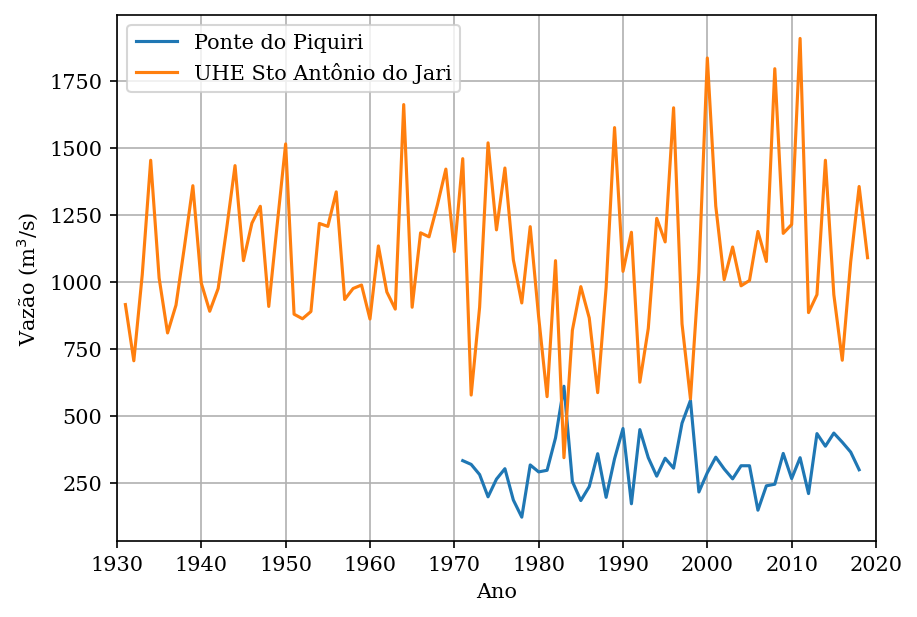

In [15]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(pp_anual, label="Ponte do Piquiri")
ax.plot(sj_anual, label="UHE Sto Antônio do Jari")

ax.set_xticks(range(1930,2021,10))
ax.set_xlabel('Ano')
ax.set_xlim([1930, 2020])

ax.set_ylabel('Vazão (m$^3$/s)')

ax.legend()
ax.grid()

fig.savefig("vazao_anual.png", format="png", dpi=300)
plt.show()

### Afluência média anual normalizada

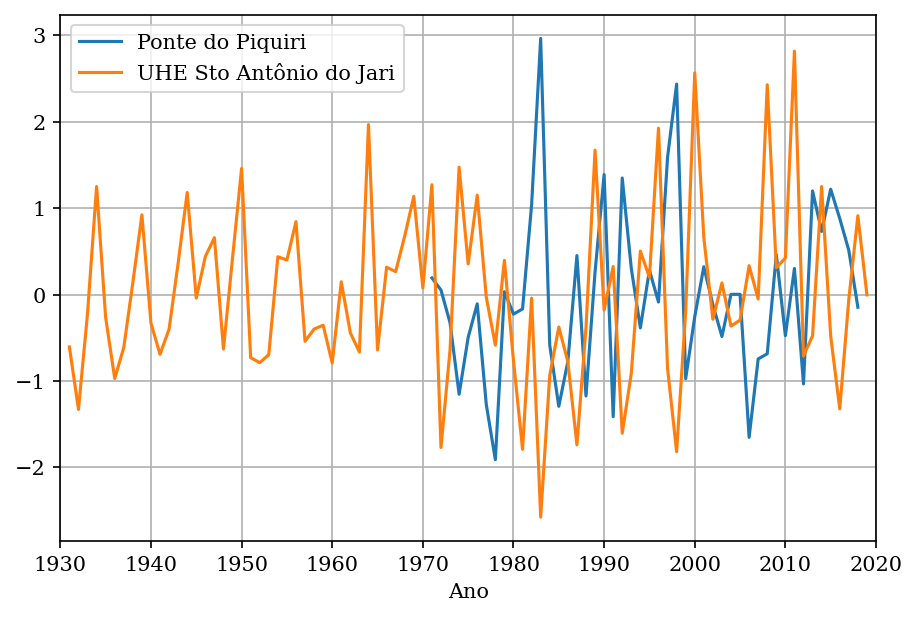

In [16]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot((pp_anual - pp_anual.mean()) / pp_anual.std(), label="Ponte do Piquiri")
ax.plot((sj_anual - sj_anual.mean()) / sj_anual.std(), label="UHE Sto Antônio do Jari")

ax.set_xlabel('Ano')
ax.set_xlim([1930, 2020])
ax.set_xticks(range(1930,2021,10))

ax.legend()
ax.grid()

fig.savefig("vazao_anual_normalizada.png", format="png", dpi=300)
plt.show()

### Média e desvio padrão

#### Ponte do Piquiri

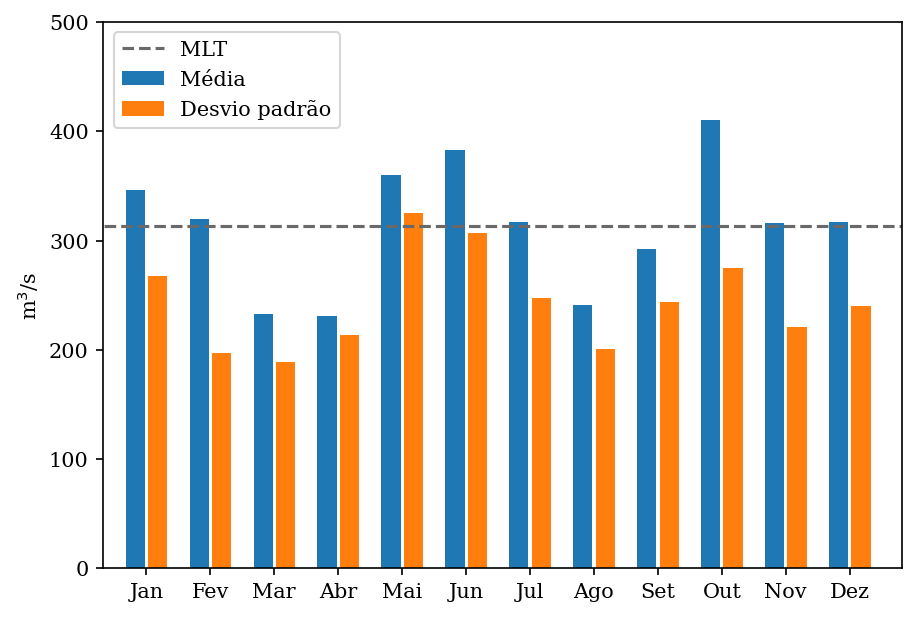

In [17]:
fig, ax = plt.subplots(constrained_layout=True)

ax.bar(np.arange(12), pp_stats_mensal.loc["Média"], width=0.3, label="Média")
ax.bar(np.arange(12) + 0.35, pp_stats_mensal.loc["Desvio Padrão"], width=0.3, label="Desvio padrão")
ax.plot(range(-1, 13), pp_anual.mean() * np.ones(14), "--", color="dimgray", label="MLT")

ax.set_xlim([-0.5, 12])
ax.set_xticks(np.arange(12) + 0.175)
ax.set_xticklabels(pp_stats_mensal.columns)

ax.set_ylim([0, 500])
ax.set_ylabel("m$^3$/s")

ax.legend()

fig.savefig("media_std_pp.png", format="png", dpi=300)
plt.show()

#### UHE Santo Antônio do Jari

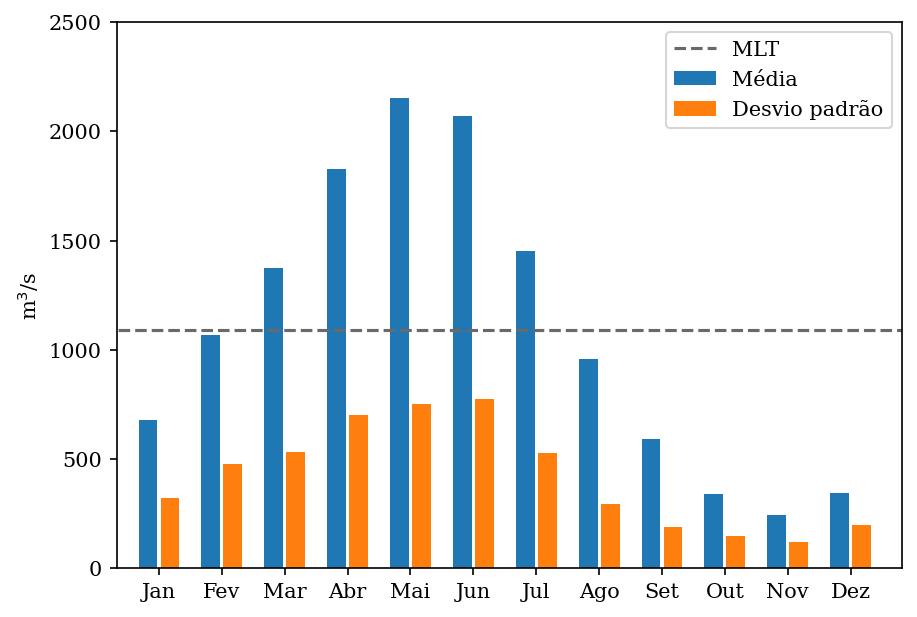

In [18]:
fig, ax = plt.subplots(constrained_layout=True)

ax.bar(np.arange(12), sj_stats_mensal.loc["Média"], width=0.3, label="Média")
ax.bar(np.arange(12) + 0.35, sj_stats_mensal.loc["Desvio Padrão"], width=0.3, label="Desvio padrão")
ax.plot(range(-1, 13), sj_anual.mean() * np.ones(14), "--", color="dimgray", label="MLT")

ax.set_xlim([-0.5, 12])
ax.set_xticks(np.arange(12) + 0.175)
ax.set_xticklabels(sj_stats_mensal.columns)

ax.set_ylim([0, 2500])
ax.set_ylabel("m$^3$/s")

ax.legend()

fig.savefig("media_std_sj.png", format="png", dpi=300)
plt.show()

### Histograma e Box-Plot

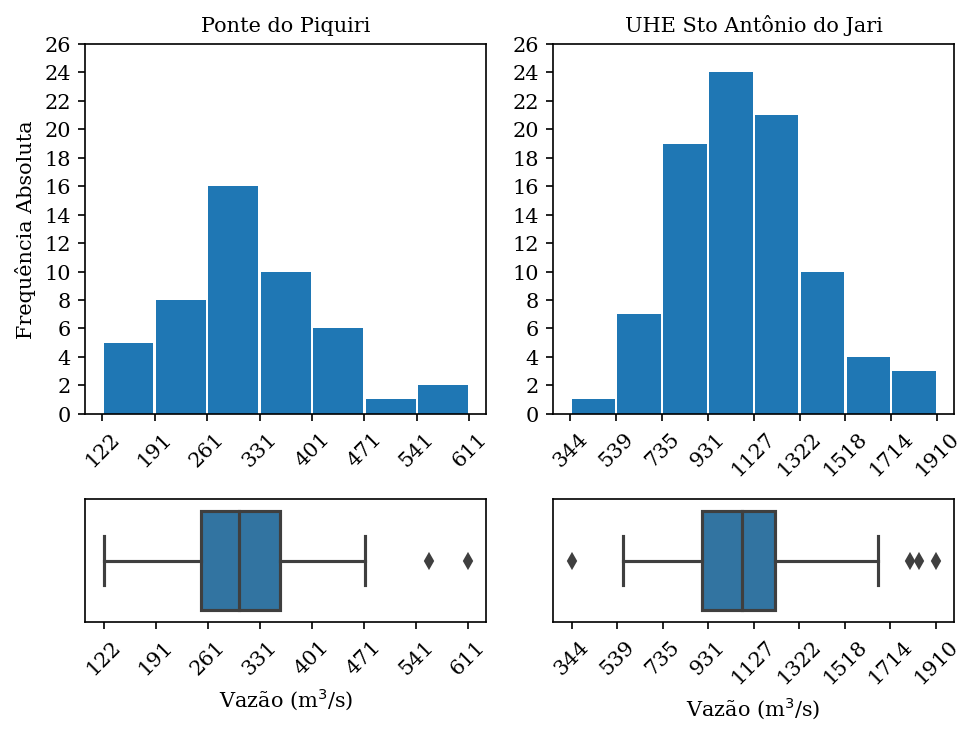

In [19]:
fig, ax = plt.subplots(2, 2, 
    constrained_layout=True, gridspec_kw={"height_ratios":[3, 1]},
    figsize=[6.4, 4.8],
)

_, pp_hist_limits, _ = ax[0, 0].hist(
        x=pp_anual, bins='sturges', alpha=1, rwidth=0.95,
)
_, sj_hist_limits, _ = ax[0, 1].hist(
        x=sj_anual, bins='sturges', alpha=1, rwidth=0.95,
)

ax[1, 0].set_xlabel('Vazão (m$^3$/s)')
ax[0, 0].set_xticks(pp_hist_limits)
ax[0, 0].set_yticks(range(0,27,2))
ax[0, 0].set_xticklabels(pp_hist_limits.astype(int), rotation=45)
ax[0, 0].set_ylabel("Frequência Absoluta")
ax[0, 0].set_title("Ponte do Piquiri", fontsize=10)

ax[1, 1].set_xlabel('Vazão (m$^3$/s)')
ax[0, 1].set_xticks(sj_hist_limits)
ax[0, 1].set_yticks(range(0,27,2))
ax[0, 1].set_xticklabels(sj_hist_limits.astype(int), rotation=45)
ax[0, 1].set_title("UHE Sto Antônio do Jari", fontsize=10)

sns.boxplot(data=np.array(pp_anual), orient="h", ax=ax[1,0])
ax[1, 0].set_yticks([])
ax[1, 0].set_xticks(pp_hist_limits)
ax[1, 0].set_xticklabels(pp_hist_limits.astype(int), rotation=45)

sns.boxplot(data=np.array(sj_anual), orient="h", ax=ax[1,1])
ax[1, 1].set_yticks([])
ax[1, 1].set_xticks(sj_hist_limits)
ax[1, 1].set_xticklabels(sj_hist_limits.astype(int), rotation=45)

fig.savefig("hist_box_plot.png", format="png", dpi=300)
plt.show()

del pp_hist_limits, sj_hist_limits

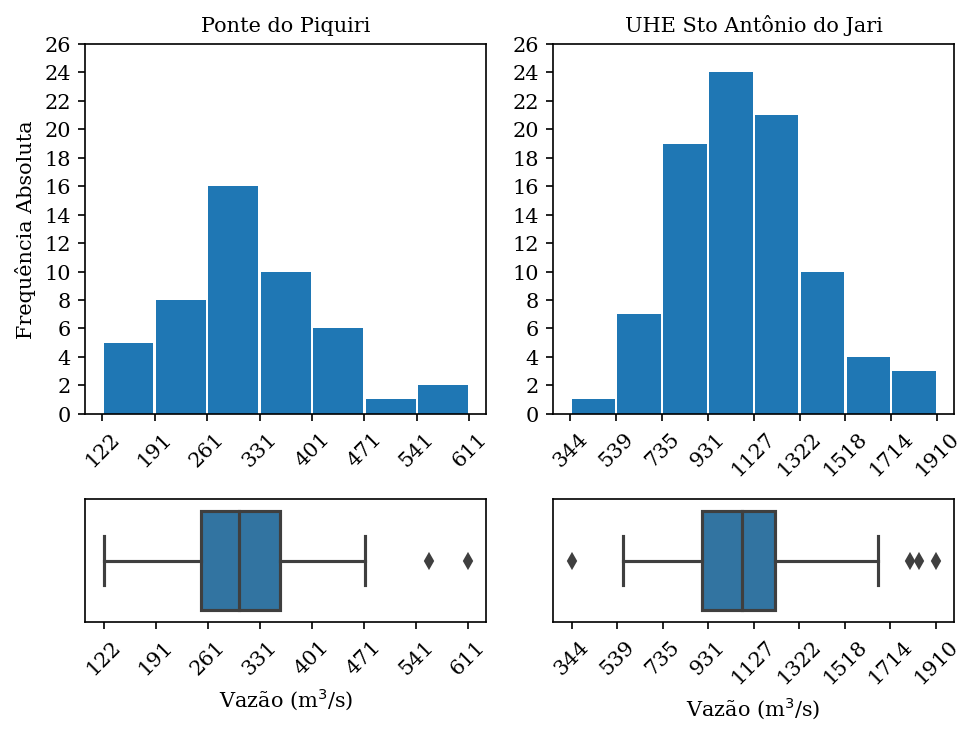

In [19]:
fig, ax = plt.subplots(2, 2, 
    constrained_layout=True, gridspec_kw={"height_ratios":[3, 1]},
    figsize=[6.4, 4.8],
)

_, pp_hist_limits, _ = ax[0, 0].hist(
        x=pp_anual, bins='sturges', alpha=1, rwidth=0.95,
)
_, sj_hist_limits, _ = ax[0, 1].hist(
        x=sj_anual, bins='sturges', alpha=1, rwidth=0.95,
)

ax[1, 0].set_xlabel('Vazão (m$^3$/s)')
ax[0, 0].set_xticks(pp_hist_limits)
ax[0, 0].set_yticks(range(0,27,2))
ax[0, 0].set_xticklabels(pp_hist_limits.astype(int), rotation=45)
ax[0, 0].set_ylabel("Frequência Absoluta")
ax[0, 0].set_title("Ponte do Piquiri", fontsize=10)

ax[1, 1].set_xlabel('Vazão (m$^3$/s)')
ax[0, 1].set_xticks(sj_hist_limits)
ax[0, 1].set_yticks(range(0,27,2))
ax[0, 1].set_xticklabels(sj_hist_limits.astype(int), rotation=45)
ax[0, 1].set_title("UHE Sto Antônio do Jari", fontsize=10)

sns.boxplot(data=np.array(pp_anual), orient="h", ax=ax[1,0])
ax[1, 0].set_yticks([])
ax[1, 0].set_xticks(pp_hist_limits)
ax[1, 0].set_xticklabels(pp_hist_limits.astype(int), rotation=45)

sns.boxplot(data=np.array(sj_anual), orient="h", ax=ax[1,1])
ax[1, 1].set_yticks([])
ax[1, 1].set_xticks(sj_hist_limits)
ax[1, 1].set_xticklabels(sj_hist_limits.astype(int), rotation=45)

fig.savefig("hist_box_plot.png", format="png", dpi=300)
plt.show()

del pp_hist_limits, sj_hist_limits

## Distribuição de probabilidades

In [20]:
# Posições de plotagem
# Ponte do Piquiri
n = len(pp_anual)
pp_pos_plot = np.arange(1, n+1) / (n+1)
# UHE Sto Antônio do Jari
n = len(sj_anual)
sj_pos_plot = np.arange(1, n+1) / (n+1)

# Normal
pp_norm = stats.norm.ppf(pp_pos_plot, loc=pp_anual.mean(), scale=pp_anual.std())
sj_norm = stats.norm.ppf(sj_pos_plot, loc=sj_anual.mean(), scale=sj_anual.std())

# Log-normal
pp_lognorm2 = stats.norm.ppf(pp_pos_plot, loc=np.log(pp_anual).mean(), scale=np.log(pp_anual).std())
pp_lognorm2 = np.exp(pp_lognorm2)
sj_lognorm2 = stats.norm.ppf(sj_pos_plot, loc=np.log(sj_anual).mean(), scale=np.log(sj_anual).std())
sj_lognorm2 = np.exp(sj_lognorm2)

# Log-normal 3 parâmetros
delta_pp = (pp_anual.min() * pp_anual.max() - pp_anual.median() ** 2) / (pp_anual.min() + pp_anual.max() - 2 * pp_anual.median())
delta_sj = (sj_anual.min() * sj_anual.max() - sj_anual.median() ** 2) / (sj_anual.min() + sj_anual.max() - 2 * sj_anual.median())
pp_lognorm3 = stats.norm.ppf(pp_pos_plot, loc=np.log(pp_anual-delta_pp).mean(), scale=np.log(pp_anual-delta_pp).std())
pp_lognorm3 = np.exp(pp_lognorm3) + delta_pp
sj_lognorm3 = stats.norm.ppf(sj_pos_plot, loc=np.log(sj_anual-delta_sj).mean(), scale=np.log(sj_anual-delta_sj).std())
sj_lognorm3 = np.exp(sj_lognorm3) + delta_sj

del n, delta_pp, delta_sj

### Plotagem das distribuições 

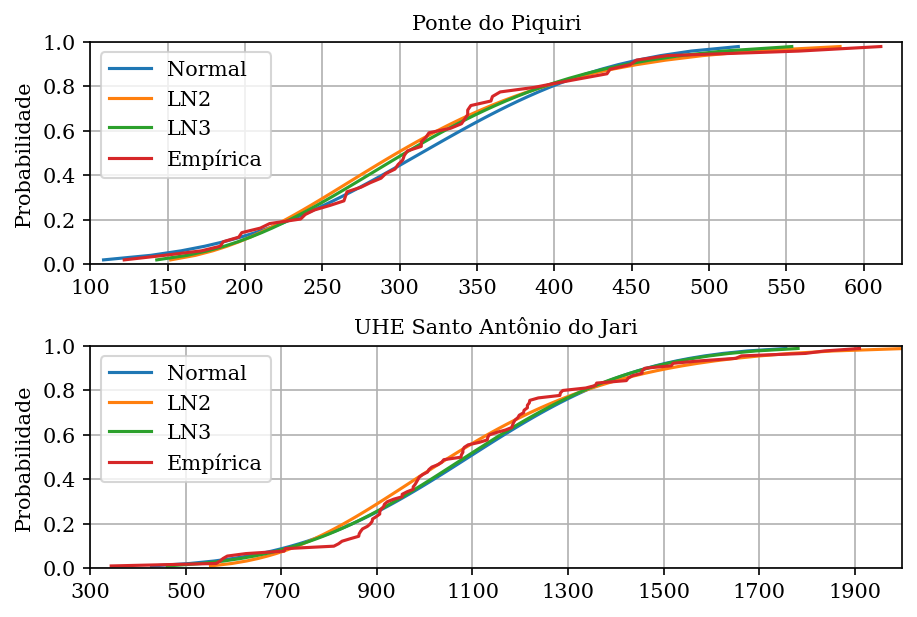

In [21]:
fig, ax = plt.subplots(2, 1, constrained_layout=True)

ax[0].plot(pp_norm, pp_pos_plot, label="Normal")
ax[0].plot(pp_lognorm2, pp_pos_plot, label="LN2")
ax[0].plot(pp_lognorm3, pp_pos_plot, label="LN3")
ax[0].plot(pp_anual.sort_values(), pp_pos_plot, label="Empírica")
ax[0].set_title("Ponte do Piquiri", fontsize=10)
ax[0].set_ylabel("Probabilidade")
ax[0].set_xlim([100, 625])
ax[0].set_xticks([i for i in range(100, 625, 50)])
ax[0].set_ylim([0, 1])
ax[0].legend()
ax[0].grid()

ax[1].plot(sj_norm, sj_pos_plot, label="Normal")
ax[1].plot(sj_lognorm2, sj_pos_plot, label="LN2")
ax[1].plot(sj_lognorm3, sj_pos_plot, label="LN3")
ax[1].plot(sj_anual.sort_values(), sj_pos_plot, label="Empírica")
ax[1].set_title("UHE Santo Antônio do Jari", fontsize=10)
ax[1].set_xlim([300, 2000])
ax[1].set_xticks([i for i in range(300, 2000, 200)])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Probabilidade")
ax[1].legend()
ax[1].grid()

fig.savefig("pdf.png", format="png", dpi=300)
plt.show()

del pp_pos_plot, sj_pos_plot

# Atividade 2

Escolher ao menos três testes estatísticos para detecção de tendências e aplicar nas séries selecionadas no Trabalho 1, considerando a escala anual. Os critérios para escolha são: (i) um (1) teste envolvendo divisão da série em subamostras; (ii) um (1) teste aplicado na amostra inteira; e (iii) um (1) teste sobre a variância. Deixar claras as premissas consideradas (ex.: a série possui correlação significativa? Se sim, foi aplicado o procedimento de pre-whitening? Qual foi o critério utilizado para a escolha dos testes? Qual foi o critério escolhido para a separação das subamostras?). É permitido escolher algum outro teste não mostrado em aula, desde que o trabalho contenha a descrição de como ele funciona. Lembrar de discutir os resultados obtidos.

## Função de autocorrelação

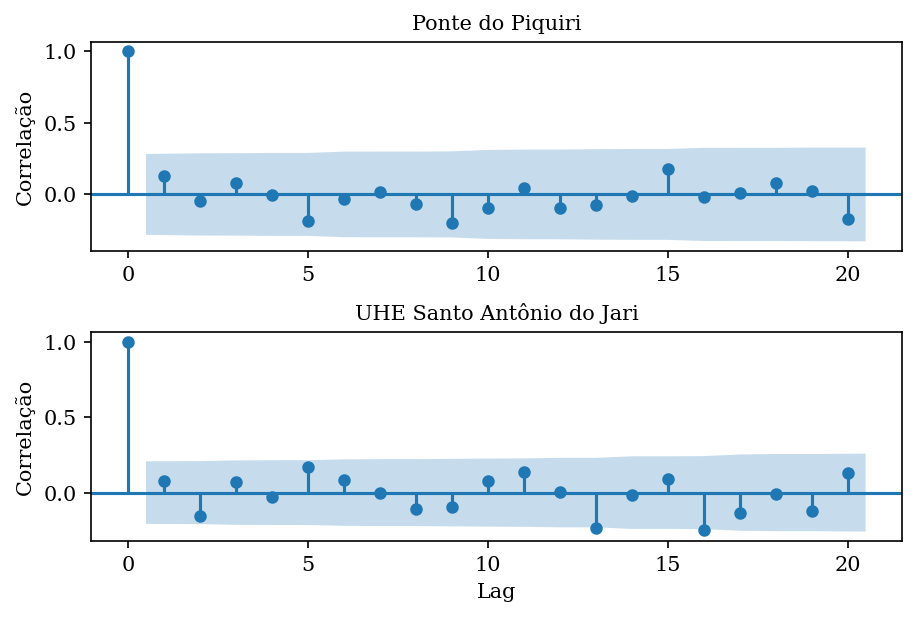

In [22]:
fig, ax = plt.subplots(2, 1, constrained_layout=True)

smapi.graphics.tsa.plot_acf(pp_anual, lags=20, ax=ax[0], title=None)
ax[0].set_ylabel("Correlação")
ax[0].set_title("Ponte do Piquiri", fontsize=10)

smapi.graphics.tsa.plot_acf(sj_anual, lags=20, ax=ax[1], title=None)
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Correlação")
ax[1].set_title("UHE Santo Antônio do Jari", fontsize=10)

fig.savefig("acf.png", format="png", dpi=300)
plt.show()

## Testes de hipótese

- **Nomenclatura**
    - `pp_teste` : var. auxiliar com estatísticas de Ponte do Piquiri
    - `sj_teste` : var. auxiliar com estatísticas de Santo Antônio do Jari
    - `teste_hipotese` : `pd.DataFrame` com as séries em linha e as estatísticas em coluna

In [23]:
pp_teste = {}
sj_teste = {}

### Mann-Kendall - amostra inteira

**Retorno**
- ``trend`` : tells the trend (increasing, decreasing or no trend)
- ``h`` : True (if trend is present) or False (if trend is absence)
- ``p`` : p-value of the significance test
- ``z`` : normalized test statistics
- ``Tau`` : Kendall Tau
- ``s`` : Mann-Kendal's score
- ``var_s`` : Variance S
- ``slope`` : Theil-Sen estimator/slope
- ``intercept`` : intercept of Kendall-Theil Robust Line

In [24]:
pp_teste["MK p-valor"] =  mk.original_test(pp_anual, alpha=0.05).p
pp_teste["MK score"]   =  mk.original_test(pp_anual, alpha=0.05).s

sj_teste["MK p-valor"] =  mk.original_test(sj_anual, alpha=0.05).p
sj_teste["MK score"]   =  mk.original_test(sj_anual, alpha=0.05).s

### Pettitt - subamostra

**Retorno**
- ``h`` : True (if data is nonhomogeneous) or False (if data is homogeneous)
- ``cp`` : probable change point location index
- ``p`` : p-value of the significance test
- ``U`` : Maximum of absolute Pettitt's U Statistics
- ``avg`` : mean values at before and after change point

In [25]:
pp_teste["Pettitt p-valor"], pp_teste["Pettitt U stats"], pp_teste["Pettitt cp"] = hg.pettitt_test(pp_anual)[1:4]
sj_teste["Pettitt p-valor"], sj_teste["Pettitt U stats"], sj_teste["Pettitt cp"] = hg.pettitt_test(sj_anual)[1:4]

### Lilliefors - normalidade dos dados 

**Retorno:**
- ``ksstat`` : float  
    Kolmogorov-Smirnov test statistic with estimated mean and variance.
- ``pvalue`` : float  
    If the pvalue is lower than some threshold, e.g. 0.05, then we can
    reject the Null hypothesis that the sample comes from a normal
    distribution.

In [26]:
pp_teste["Lilliefors p-valor"], pp_teste["Lilliefors KS stats"] = sm.stats.diagnostic.lilliefors(pp_anual, dist='norm', pvalmethod='table')
sj_teste["Lilliefors p-valor"], sj_teste["Lilliefors KS stats"] = sm.stats.diagnostic.lilliefors(sj_anual, dist='norm', pvalmethod='table')

### F-Snedecor - variância

In [27]:
pp_f_snedecor = np.zeros([len(pp_anual) - 3, 3])
sj_f_snedecor = np.zeros([len(sj_anual) - 3, 3])

# Ponte do Piquiri
serie = pp_anual

for n in range(pp_f_snedecor.shape[0]):  # desconsidera séries de um valor apenas (div. por N-1 indefinido)

    sub1 = serie.iloc[:n+2]
    N = len(sub1)
    sub2 = serie.iloc[n+2:]
    M = len(sub2)

    F = sub1.var() / sub2.var()

    pp_f_snedecor[n,:] = [stats.f.ppf(0.05/2, N-1, M-1), F, stats.f.ppf(1 - 0.05/2, N-1, M-1)]

# UHE Santo Antônio do Jari
serie = sj_anual

for n in range(sj_f_snedecor.shape[0]):  # desconsidera séries de um valor apenas (div. por N-1 indefinido)

    sub1 = serie.iloc[:n+2]
    N = len(sub1)
    sub2 = serie.iloc[n+2:]
    M = len(sub2)

    F = sub1.var() / sub2.var()

    sj_f_snedecor[n,:] = [stats.f.ppf(0.05/2, N-1, M-1), F, stats.f.ppf(1 - 0.05/2, N-1, M-1)]

del sub1, sub2, N, M, F, serie, n

# Organizando resultados
pp_f_snedecor = pd.DataFrame(
    pp_f_snedecor, columns=["F(alpha/2)", "F", "F(1-alpha/2)"], index=range(2, len(pp_anual)-1)
)

sj_f_snedecor = pd.DataFrame(
    sj_f_snedecor, columns=["F(alpha/2)", "F", "F(1-alpha/2)"], index=range(2, len(sj_anual)-1)
)

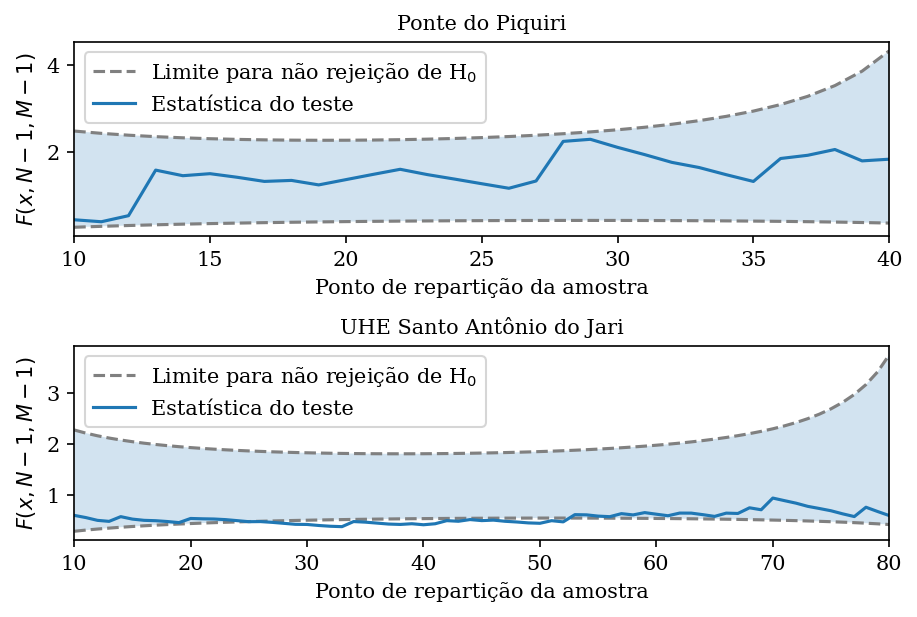

In [28]:
fig, ax = plt.subplots(2, 1, constrained_layout=True)

pp_f_snedecor.loc[range(10,41)].plot(ax=ax[0], 
    style=["--", "-", "--"], color=["gray", "C0", "gray"]
)
ax[0].set_title("Ponte do Piquiri", fontsize=10)
ax[0].legend(["Limite para não rejeição de H$_0$", "Estatística do teste"])
ax[0].set_xlabel("Ponto de repartição da amostra")
ax[0].set_xlim([10,40])
ax[0].set_ylabel("$F(x, N-1, M-1)$")
ax[0].fill_between(range(10,41), 
    pp_f_snedecor["F(alpha/2)"].loc[range(10,41)], pp_f_snedecor["F(1-alpha/2)"].loc[range(10,41)], alpha=0.2,
)

sj_f_snedecor.loc[range(10,81)].plot(ax=ax[1], 
    style=["--", "-", "--"], color=["gray", "C0", "gray"]
)
ax[1].set_title("UHE Santo Antônio do Jari", fontsize=10)
ax[1].legend(["Limite para não rejeição de H$_0$", "Estatística do teste"])
ax[1].set_xlabel("Ponto de repartição da amostra")
ax[1].set_xlim([10,80])
ax[1].set_ylabel("$F(x, N-1, M-1)$")
ax[1].fill_between(range(10,81), 
    sj_f_snedecor["F(alpha/2)"].loc[range(10,81)], sj_f_snedecor["F(1-alpha/2)"].loc[range(10,81)], alpha=0.2,
)

fig.savefig("f_snedecor.png", format="png", dpi=300)
plt.show()

### Resumo dos testes

In [29]:
# Organização dos resultados
teste_hipotese = pd.DataFrame(
    [pp_teste, sj_teste], index=["Ponte do Piquiri", "Santo Antônio do Jari"]
).round(3)

del pp_teste, sj_teste

In [30]:
teste_hipotese

,MK p-valor,MK score,Pettitt p-valor,Pettitt U stats,Pettitt cp,Lilliefors p-valor,Lilliefors KS stats
Ponte do Piquiri,0.152,162.0,18,0.310,172.0,0.103,0.230
Santo Antônio do Jari,0.632,136.0,69,0.667,328.0,0.094,0.066


# Atividade 3

**Parte 1:**

Ajuste um modelo do tipo ARMA(p,q) à série de vazões médias anuais. Lembrar que a transformação logarítmica pode ser necessária. Para simplificar o exercício, desconsidere as questões relativas a um eventual comportamento não estacionário da série em questão. Com base nas diversas técnicas vistas em aula, analisar:

a) Qual foi o modelo identificado para a série de vazões escolhida? Justifique sua análise, considerando os métodos utilizados nas fases de identificação-estimação-validação.

b) Use o modelo identificado no item (a) para gerar uma sequência de múltiplas séries sintéticas (mínimo 30) com o mesmo comprimento da série histórica. A quantidade de séries sintéticas a gerar fica a seu critério.

c) Faça uma análise sobre as séries sintéticas geradas comparando suas principais estatísticas com as da série histórica. Considere agregar incerteza aos estimadores por meio de desvios-padrão, intervalos de confiança, box-plots, etc.

**Parte 2:**

Dentre os métodos para dimensionamento de reservatórios apresentados em aula, escolha um deles e aplique nas seguintes situações considerando regularização de 60% em relação à vazão média de longo termo:

a) Utilizando a série histórica da localidade escolhida.

b) Utilizando as séries sintéticas obtidas como produto do item (b) na Parte 1.

c) Tecer comentários sobre diferenças encontradas na comparação entre os volumes estimados para a série histórica e para as séries sintéticas.

## Função de autocorrelação parcial

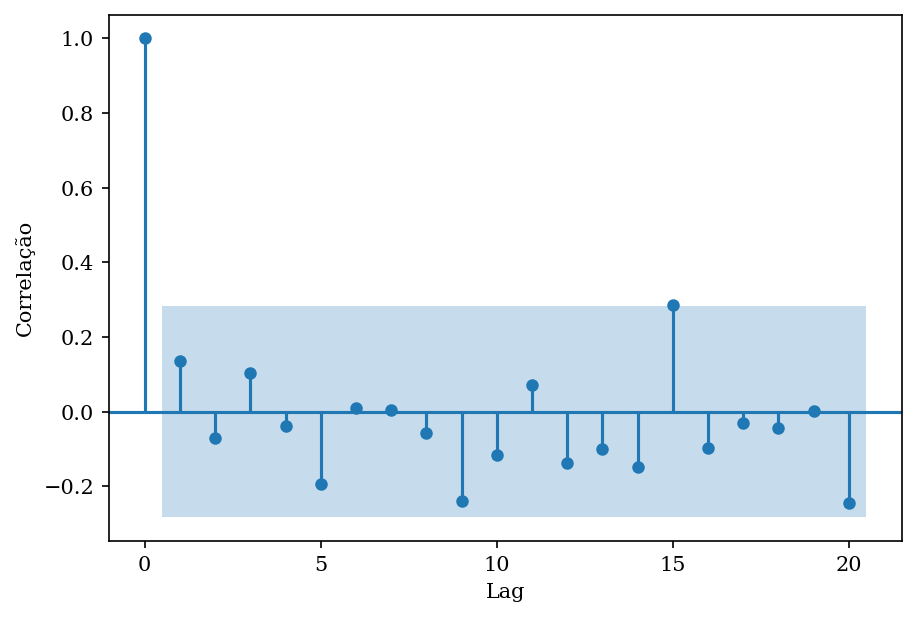

In [31]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
sm.api.graphics.tsa.plot_pacf(pp_anual, lags=20, ax=ax, title=None)

ax.set_xlabel("Lag")
ax.set_ylabel("Correlação")

plt.savefig("pacf.png", format="png", dpi=300)
plt.show()

## Leitura das séries sintéticas

In [32]:
series_sint = pd.read_excel("series_sint.xlsx", index_col=0)

In [33]:
series_sint

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
1,233.708,219.597,448.927,348.287,206.453,301.730,342.734,240.248,302.368,352.494,...,207.312,263.166,304.710,241.829,380.897,244.353,339.182,540.665,367.784,362.036
2,191.517,452.461,559.202,443.266,514.315,192.756,405.302,455.087,325.161,244.897,...,403.122,172.969,213.118,384.648,203.604,269.961,262.047,284.090,248.222,278.012
3,180.572,265.763,344.131,452.660,305.020,379.693,300.330,234.977,312.314,449.402,...,263.612,338.578,384.790,293.535,237.514,245.001,220.406,179.116,251.589,495.164
4,207.258,369.037,350.872,226.280,304.016,372.266,162.622,234.949,339.471,238.114,...,340.267,271.612,376.093,287.107,505.387,653.123,223.587,298.872,376.354,493.171
5,219.949,534.144,386.998,245.211,145.066,636.367,527.109,344.504,228.383,135.828,...,365.101,369.753,353.227,143.572,175.690,241.945,522.324,254.063,210.284,305.694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,381.832,220.047,284.990,439.864,278.719,375.677,510.847,386.589,462.921,282.112,...,401.685,245.072,256.987,207.535,283.141,338.610,289.299,260.590,280.494,292.496
997,387.094,295.245,255.645,177.892,304.154,230.879,272.173,322.671,340.090,339.732,...,335.249,630.025,264.979,314.652,360.976,340.247,255.097,377.264,479.311,212.518
998,173.837,377.750,246.345,357.256,495.899,352.390,341.412,365.953,191.562,274.438,...,310.778,338.287,420.475,348.246,327.135,258.925,198.030,328.352,309.465,186.863
999,423.160,258.003,524.484,434.179,173.726,432.257,315.603,239.059,255.701,452.863,...,417.785,284.100,249.400,246.439,232.829,321.235,225.392,265.024,233.934,403.632


## Análise sequencial de picos

### Série histórica

In [140]:
defluencia = pp_anual.mean() * 0.6

volume = np.zeros(len(pp_anual))

for t, _ in enumerate(volume):
    volume[t] = max(0, defluencia - pp_anual.iloc[t] + volume[t-1])

In [141]:
volume.max()

68.52499999999998

### Séries sintéticas

In [147]:
volume_sint = np.zeros([1000, 2 * len(pp_anual)])  # duas vezes o histórico

for s in range(1000):
    serie = series_sint.iloc[s]
    
    for t in range(48):
        volume_sint[s, t] = max(0, defluencia - serie.iloc[t] + volume_sint[s, t-1])
        
    for t in range(48):
        volume_sint[s, t+48] = max(0, defluencia - serie.iloc[t] + volume_sint[s, t-1+48])

In [169]:
volume_sint.max(axis=1).mean()

60.134296599999985

In [170]:
volume_sint.max(axis=1).std()

34.659958036349785

In [202]:
stats.t.ppf(1 - 0.05/2, 999)

1.9623414611334487

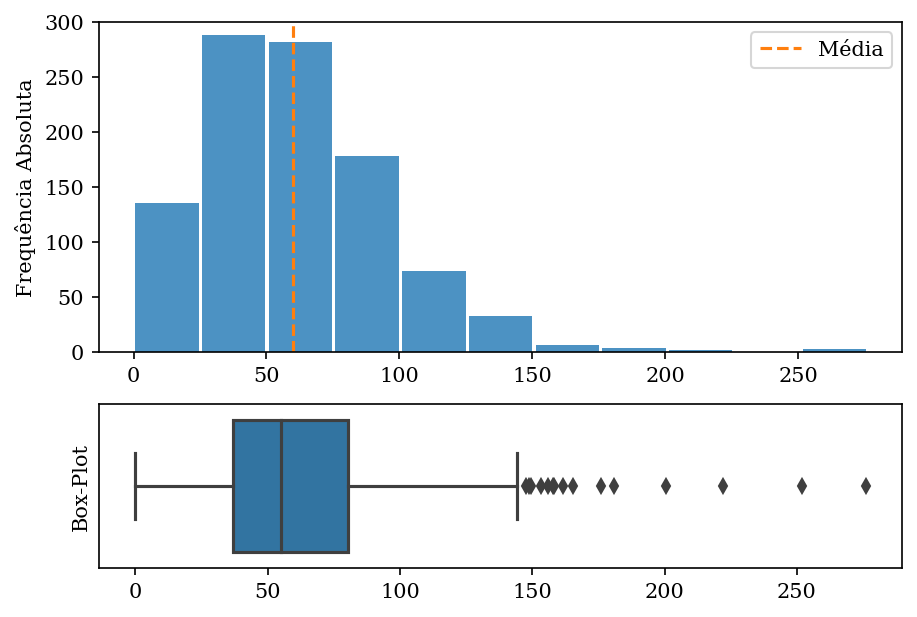

In [225]:
fig, ax = plt.subplots(2, 1, constrained_layout=True, gridspec_kw={"height_ratios":[2, 1]})

ax[0].hist(x=volume_sint.max(axis=1), bins='sturges', alpha=0.8, rwidth=0.95)
ax[0].set_ylim([0, 300])
ax[0].set_ylabel("Frequência Absoluta")
ax[0].vlines(
    volume_sint.max(axis=1).mean(), 
    0, 300, linestyle="dashed", color="C1", label="Média"
)
ax[0].legend()

sns.boxplot(data=volume_sint.max(axis=1), orient="h", ax=ax[1])
ax[1].set_yticks([])
ax[1].set_ylabel("Box-Plot")

fig.savefig("histograma_mda.png", format="png", dpi=300)
plt.show()

# Atividade 4

<center><img src="at4_cascata.png" alt="cascata" width="300"/></center>

Determinar o armazenamento máximo do sistema, nas seguintes configurações: 
- a) Sistema original (todos os reservatórios de regularização).
- b) Simulando que a usina de Sobradinho opera a fio d’água.
- c) Tecer  comentários  acerca  das  diferenças  na  capacidade  de  armazenamento  do  sistema  entre  as configurações (a) e (b)

## Caracterização das usinas

In [34]:
retiro_baixo = {
    "volume_maximo": 241.59,  # hm3
    "volume_minimo": 200.72,  # hm3
    "cota_maxima"  : 616,  # m
    "cota_minima"  : 614,  # m
    "rendimento"   : 0.008755 * 101.94,  # MW/m3/s/m
    "cota_cf"      : 577,  # m
    "perda_tipo"   : 1,  # valor constante
    "perda_valor"  : 3,  # m
}

tres_marias = {
    "volume_maximo": 19528,  # hm3
    "volume_minimo": 4250,  # hm3
    "cota_maxima"  : 572.5,  # m
    "cota_minima"  : 549.2,  # m
    "rendimento"   : 0.008564 * 101.94,  # MW/m3/s/m
    "cota_cf"      : 515.7,  # m
    "perda_tipo"   : 2,  # % da altura bruta
    "perda_valor"  : 0.6,  # %
}

queimado = {
    "volume_maximo": 557,  # hm3
    "volume_minimo": 95.25,  # hm3
    "cota_maxima"  : 829,  # m
    "cota_minima"  : 811,  # m
    "rendimento"   : 0.008829 * 101.94,  # MW/m3/s/m
    "cota_cf"      : 637.5,  # m
    "perda_tipo"   : 2,  # % da altura bruta
    "perda_valor"  : 5.8,  # %
}

sobradinho = {
    "volume_maximo": 34116,  # hm3
    "volume_minimo": 5447,  # hm3
    "cota_maxima"  : 392.5,  # m
    "cota_minima"  : 380.5,  # m
    "rendimento"   : 0.009023 * 101.94,  # MW/m3/s/m
    "cota_cf"      : 362.5,  # m
    "perda_tipo"   : 2,  # % da altura bruta
    "perda_valor"  : 0.5,  # %
}

itaparica = {
    "volume_maximo": 10782,  # hm3
    "volume_minimo": 7234,  # hm3
    "cota_maxima"  : 304,  # m
    "cota_minima"  : 299,  # m
    "rendimento"   : 0.008931 * 101.94,  # MW/m3/s/m
    "cota_cf"      : 251.5,  # m
    "perda_tipo"   : 2,  # % da altura bruta
    "perda_valor"  : 0.8,  # %
}

hidro = pd.DataFrame(
    data = [itaparica, sobradinho, queimado, tres_marias, retiro_baixo],
    index = ["itaparica", "sobradinho", "queimado", "tres_marias", "retiro_baixo"],
)

del itaparica, sobradinho, queimado, tres_marias, retiro_baixo

hidro

,volume_maximo,volume_minimo,cota_maxima,cota_minima,rendimento,cota_cf,perda_tipo,perda_valor
itaparica,10782.00,7234.00,304.0,299.0,0.910426,251.5,2,0.8
sobradinho,34116.00,5447.00,392.5,380.5,0.919805,362.5,2,0.5
queimado,557.00,95.25,829.0,811.0,0.900028,637.5,2,5.8
tres_marias,19528.00,4250.00,572.5,549.2,0.873014,515.7,2,0.6
retiro_baixo,241.59,200.72,616.0,614.0,0.892485,577.0,1,3.0


$$
K = 10^{-3} \cdot g \cdot \mu_{HL} \cdot \eta
$$

In [35]:
# Volume útil
hidro["volume_util"] = hidro["volume_maximo"] - hidro["volume_minimo"]

# Altura bruta
hidro["altura_bruta"] = (hidro["cota_maxima"] + hidro["cota_minima"]) / 2 - hidro["cota_cf"]

# Altura líquida - tipo 2
hidro["altura_liquida"] = hidro["altura_bruta"] * (1 - hidro["perda_valor"]/100)

# Correção para perda tipo 1
mask = hidro["perda_tipo"] == 1  
hidro["altura_liquida"] = hidro["altura_liquida"].mask(
    mask, hidro["altura_bruta"][mask] - hidro["perda_valor"][mask]  # tipo 1
)
del mask

# Produtividade de uma usina
hidro["produtividade"] = 1e-3 * 9.80665 * hidro["altura_liquida"] * hidro["rendimento"]

In [36]:
hidro

,volume_maximo,volume_minimo,cota_maxima,cota_minima,rendimento,cota_cf,perda_tipo,perda_valor,volume_util,altura_bruta,altura_liquida,produtividade
itaparica,10782.00,7234.00,304.0,299.0,0.910426,251.5,2,0.8,3548.00,50.00,49.6000,0.442840
sobradinho,34116.00,5447.00,392.5,380.5,0.919805,362.5,2,0.5,28669.00,24.00,23.8800,0.215402
queimado,557.00,95.25,829.0,811.0,0.900028,637.5,2,5.8,461.75,182.50,171.9150,1.517367
tres_marias,19528.00,4250.00,572.5,549.2,0.873014,515.7,2,0.6,15278.00,45.15,44.8791,0.384225
retiro_baixo,241.59,200.72,616.0,614.0,0.892485,577.0,1,3.0,40.87,38.00,35.0000,0.306330


## Método da energia natural

### Armazenamento máximo do sistema

$$
A_{\text{máx}} = \sum_{r \in R} \left[ \dfrac{V_r}{2.628} \left( \sum_{u \in U_{r}} K_u \right) \right]
$$

In [39]:
hidro["A_max"] = float(0)

hidro.at["itaparica", "A_max"] = hidro.at["itaparica", "volume_util"] / 2.628 * (
    hidro.at["itaparica", "produtividade"]
)

hidro.at["sobradinho", "A_max"] = hidro.at["sobradinho", "volume_util"] / 2.628 * (
    hidro.at["itaparica", "produtividade"] 
        + hidro.at["sobradinho", "produtividade"]
)

hidro.at["queimado", "A_max"] = hidro.at["queimado", "volume_util"] / 2.628 * (
    hidro.at["itaparica", "produtividade"]
        + hidro.at["sobradinho", "produtividade"]
        + hidro.at["queimado", "produtividade"]
)

hidro.at["tres_marias", "A_max"] = hidro.at["tres_marias", "volume_util"] / 2.628 * (
    hidro.at["itaparica", "produtividade"]
        + hidro.at["sobradinho", "produtividade"]
        + hidro.at["tres_marias", "produtividade"]
)

hidro.at["retiro_baixo", "A_max"] = hidro.at["retiro_baixo", "volume_util"] / 2.628 * (
    hidro.at["itaparica", "produtividade"]
        + hidro.at["sobradinho", "produtividade"]
        + hidro.at["tres_marias", "produtividade"]
        + hidro.at["retiro_baixo", "produtividade"]
)

In [41]:
hidro["A_max"].sum()

14242.350195374422

Caso de UHE Sobradinho operando a fio d'água

In [42]:
hidro["A_max"].sum() - hidro.at["sobradinho", "A_max"]

7061.543987887961

### Energia natural afluente

In [43]:
vazoes = pd.read_excel(
    "cascata.xlsx", sheet_name="flow", index_col="ano", 
)

ena = pd.DataFrame()

for usina in hidro.index:
    ena[usina] = hidro.at[usina, "produtividade"] * vazoes[usina]

<ipython-input-83-6ffee0115f59>:23: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig("vazao_ena.png", format="png", dpi=300)


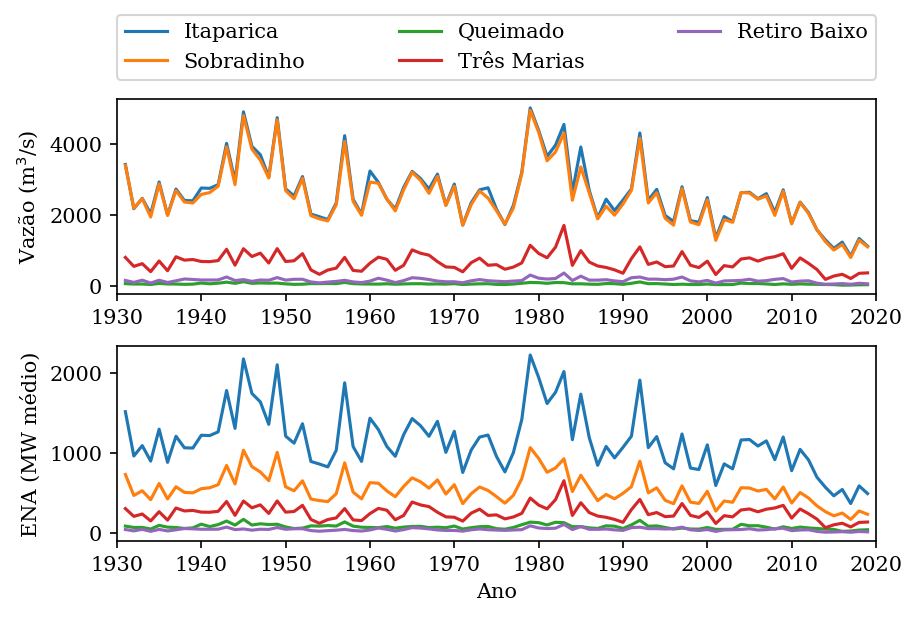

In [83]:
usinas = ["Itaparica", "Sobradinho", "Queimado", "Três Marias", "Retiro Baixo"]

fig, ax = plt.subplots(2, 1, constrained_layout=True)

for i, usina in enumerate(hidro.index):
    ax[0].plot(vazoes[usina], label=usinas[i])
    ax[1].plot(ena[usina], label=usinas[i])

ax[1].set_xlabel("Ano")

ax[0].set_xticks([1930 + i for i in np.arange(0, 100, 10)])
ax[1].set_xticks([1930 + i for i in np.arange(0, 100, 10)])

ax[0].set_xlim([1930, 2020])
ax[1].set_xlim([1930, 2020])

ax[0].set_ylabel("Vazão (m$^3$/s)")
ax[1].set_ylabel("ENA (MW médio)")

ax[0].legend(bbox_to_anchor=(0,1.1,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)

plt.savefig("vazao_ena.png", format="png", dpi=300)
plt.show()

del usina, usinas

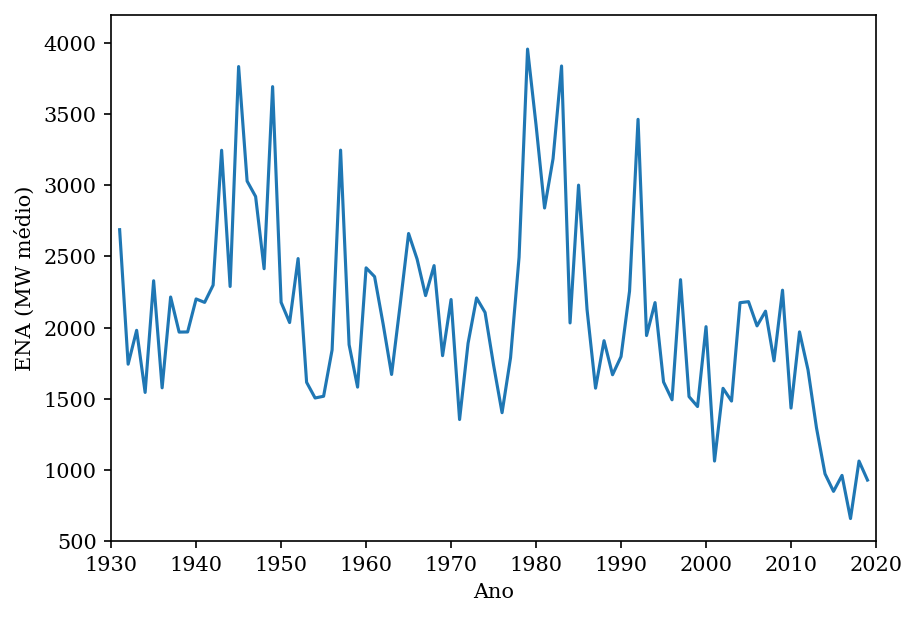

In [82]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(ena.sum(axis=1))

ax.set_xticks([1930 + i for i in np.arange(0, 100, 10)])
ax.set_xlim([1930, 2020])
ax.set_ylim([500, 4200])
ax.set_xlabel("Ano")
ax.set_ylabel("ENA (MW médio)")

fig.savefig("ena_sistema.png", format="png", dpi=300)
plt.show()

del i

## Curva de regularização do sistema

In [84]:
R = np.linspace(0, 1, 11)  # níveis de regularização

ena_sistema = ena.sum(axis=1)
mlt         = ena_sistema.mean()
volume_ena  = np.zeros([11, len(ena_sistema)])

for i, reg in enumerate(R):  # para cada nível de reg.
    energia_firme = reg * mlt
    
    for t, _ in enumerate(volume_ena[i, :]):  # Rippl censurado
        volume_ena[i, t] = max(0, energia_firme - ena_sistema.iloc[t] + volume_ena[i, t-1])

curva_regularizacao = volume_ena.max(axis=1)

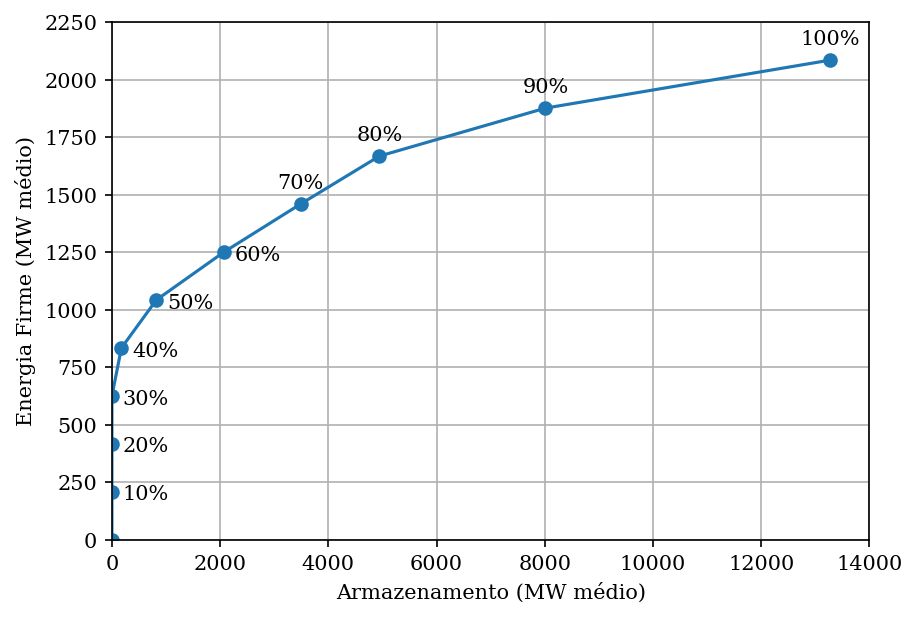

In [142]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(curva_regularizacao, R * mlt, marker="o")

ax.set_xlabel("Armazenamento (MW médio)")
ax.set_xticks(range(0, 15000, 2000))
ax.set_xlim([0, 14000])

ax.set_ylabel("Energia Firme (MW médio)")
ax.set_yticks(range(0, 2500, 250))
ax.set_ylim([0, 2250])

ax.grid()

for i, r in enumerate(R):
    if i == 0:
        continue
    if i < 7:
        ax.text(curva_regularizacao[i] + 200, r * mlt - 35, str(int(r * 100)) + "%")
    else:
        ax.text(curva_regularizacao[i], r * mlt + 50, str(int(r * 100)) + "%", horizontalalignment="center", verticalalignment="bottom")
        
fig.savefig("curva_reg_ena.png", format="png", dpi=300)
plt.show()

del t, reg, r, R, i, energia_firme, ena_sistema, curva_regularizacao